In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE # dimensionality reduction
import re

# Membuat fungsi untuk memisahkan kata berdasarkan huruf kapital (berguna untuk membuat label di plot)
def split_by_capital(word):
    return re.sub(r'(?<!^)([A-Z])', r' \1', word)

In [2]:
df = pd.read_csv('transactions.csv')


In [3]:
df.shape

(641914, 23)

In [4]:
df.dtypes

accountNumber                 int64
customerId                    int64
creditLimit                   int64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                float64
posConditionCode            float64
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                       int64
enteredCVV                    int64
cardLast4Digits               int64
transactionType              object
isFraud                        bool
currentBalance              float64
cardPresent                    bool
expirationDateKeyInMatch       bool
dtype: object

In [5]:
''' 
Insights: 
Tipe data pada dataset tampak normal tapi ada anomali yang mana 'cardLast4Digits', 'enteredCVV' dan 'cardCVV' merupakan int
Seharusnya 'cardLast4Digits' adalah string karena hanya berisi 4 digit terakhir dari nomor kartu kredit 
serta 'enteredCVV' & 'cardCVV' juga string karena berisi kode CVV pada kartu kredit

Contoh jika ada kasus digit akhirannya '0123' maka kolom int tersebut hanya akan menyimpan '123'. 
Maka urgensi untuk mengubah tipe data kolom ini menjadi string sangat penting untuk menjaga integritas data.
'''

" \nInsights: \nTipe data pada dataset tampak normal tapi ada anomali yang mana 'cardLast4Digits', 'enteredCVV' dan 'cardCVV' merupakan int\nSeharusnya 'cardLast4Digits' adalah string karena hanya berisi 4 digit terakhir dari nomor kartu kredit \nserta 'enteredCVV' & 'cardCVV' juga string karena berisi kode CVV pada kartu kredit\n\nContoh jika ada kasus digit akhirannya '0123' maka kolom int tersebut hanya akan menyimpan '123'. \nMaka urgensi untuk mengubah tipe data kolom ini menjadi string sangat penting untuk menjaga integritas data.\n"

In [6]:
df.describe()

accountNumber    customerId    creditLimit  availableMoney  \
count   6.419140e+05  6.419140e+05  641914.000000   641914.000000   
mean    5.547701e+08  5.547701e+08   10697.210608     6652.828573   
std     2.546884e+08  2.546884e+08   11460.359133     9227.132275   
min     1.005471e+08  1.005471e+08     250.000000    -1244.930000   
25%     3.223192e+08  3.223192e+08    5000.000000     1114.970000   
50%     5.438879e+08  5.438879e+08    7500.000000     3578.165000   
75%     7.862277e+08  7.862277e+08   15000.000000     8169.185000   
max     9.999853e+08  9.999853e+08   50000.000000    50000.000000   

       transactionAmount   posEntryMode  posConditionCode        cardCVV  \
count      641914.000000  638569.000000     641627.000000  641914.000000   
mean          135.162497       9.136460          3.238367     557.199927   
std           147.053302      16.961185          9.680862     257.326204   
min             0.000000       2.000000          1.000000     100.000000   
25%            32.320000       2.000000          1.000000     334.000000   
50%            85.800000       5.000000          1.000000     581.000000   
75%           189.030000       9.000000          1.000000     762.000000   
max          1825.250000      90.000000         99.000000     998.000000   

          enteredCVV  cardLast4Digits  currentBalance  
count  641914.000000    641914.000000   641914.000000  
mean      556.775160      4886.184043     4044.382035  
std       257.402639      2859.053679     5945.510224  
min         1.000000         0.000000        0.000000  
25%       333.000000      2364.000000      502.442500  
50%       580.000000      4873.000000     2151.860000  
75%       761.000000      7267.000000     5005.890000  
max       998.000000      9998.000000    47496.500000

In [7]:
''' 
Insights:

1. kolom 'cardLast4Digits' memiliki 'min' bernilai '0' yang merupakan kesalahan sangat fatal -> perlu dilakukan cleaning data pada kolom ini.
2. Kolom 'availableMoney' memiliki nilai negatif merupakan hal -> Perlu dilakukan pengecekan apakah data minus merupakan hal lumrah pada kolom tersebut.
3. Kolom 'transactionAmount' memiliki nilai '0' pada bagian 'min' (ini bisa diindikasikan sebagai traksaksi gagal) -> Perlu dilakukan pengecekan apakah transaksi dengan nilai 0 adalah hal yang lumrah.
4. Kolom 'posConditionCode' memiliki nilai 'min', '25%', '50%' dan '75%' yang bernilai '1' tapi hanya 'max' bernilai '99' -> Karena ini merupakan code mungkin itu bisa saja terjadi, tapi perlu dilakukan pengecekan dengan nilai Uniqe untuk melihat insight lebih lanjut.
5. Kolom 'cardCVV' dan 'enteredCVV' harus lah sama, tapi dibagian 'enteredCVV' terlihat nilai 'min' yaitu '1', seharusnya memiliki 3 digit jika disimpulkan secara sekilas (ada kemungkinan human error dari user (typo)) -> Perlu dilakukan analisis lebih dalam untuk melihat berapa banyak ketidaksesuaian CVV (bukan kesalahan ). 
'''

" \nInsights:\n\n1. kolom 'cardLast4Digits' memiliki 'min' bernilai '0' yang merupakan kesalahan sangat fatal -> perlu dilakukan cleaning data pada kolom ini.\n2. Kolom 'availableMoney' memiliki nilai negatif merupakan hal -> Perlu dilakukan pengecekan apakah data minus merupakan hal lumrah pada kolom tersebut.\n3. Kolom 'transactionAmount' memiliki nilai '0' pada bagian 'min' (ini bisa diindikasikan sebagai traksaksi gagal) -> Perlu dilakukan pengecekan apakah transaksi dengan nilai 0 adalah hal yang lumrah.\n4. Kolom 'posConditionCode' memiliki nilai 'min', '25%', '50%' dan '75%' yang bernilai '1' tapi hanya 'max' bernilai '99' -> Karena ini merupakan code mungkin itu bisa saja terjadi, tapi perlu dilakukan pengecekan dengan nilai Uniqe untuk melihat insight lebih lanjut.\n5. Kolom 'cardCVV' dan 'enteredCVV' harus lah sama, tapi dibagian 'enteredCVV' terlihat nilai 'min' yaitu '1', seharusnya memiliki 3 digit jika disimpulkan secara sekilas (ada kemungkinan human error dari user (typ

In [8]:
df.describe(include=['object'])
# freq adalah yang terbanyak (top)

transactionDateTime merchantName acqCountry merchantCountryCode  \
count                641914       641914     638001              641290   
unique               635472         2493          4                   4   
top     2016-01-19T04:26:56         Lyft         US                  US   
freq                      3        25311     632303              635577   

       merchantCategoryCode currentExpDate accountOpenDate  \
count                641914         641914          641914   
unique                   19            165            1826   
top           online_retail       1/5/2026      11/12/2015   
freq                 161469           4209           10137   

       dateOfLastAddressChange transactionType  
count                   641914          641325  
unique                    2186               3  
top                  20/7/2016        PURCHASE  
freq                      3948          608685

In [9]:
df.describe(include=['bool'])

isFraud cardPresent expirationDateKeyInMatch
count   641914      641914                   641914
unique       2           2                        2
top      False       False                    False
freq    630612      340453                   640945

# 2. Exploratory Data Analysis

## 2.1 Univariate Analysis

In [10]:
# Membuat fungsi plot distribusi untuk setiap kolom numerik agar kode lebih efesien
def plot_distribution(df_, column_=""):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.kdeplot(x=df_[column_].to_list(), color="blue", fill=True)
    plt.title(split_by_capital(column_) + " Distribution Plot", fontsize=14)
    plt.xlabel(split_by_capital(column_), fontsize=14)
    plt.ylabel("count", fontsize=14)
    plt.show()


In [120]:
# Membuat fungsi plot bar chart untuk setiap kolom numerik agar kode lebih efesien
def plot_bar(df_, column_, horizontal=False):
    plt.figure(figsize=(10, 6))
    if not horizontal:
        sns.countplot(data=df_, x=column_, palette="viridis", order=df_[column_].value_counts().index)
        plt.title(f'{split_by_capital(column_)} Bar Plot', fontsize=14)
        plt.xlabel(split_by_capital(column_), fontsize=14)
        plt.ylabel('Count', fontsize=14)
    else: 
        sns.countplot(data=df_, y=column_, palette="viridis", order=df_[column_].value_counts().index)  
        plt.title(f'{split_by_capital(column_)} Bar Plot', fontsize=14)
        plt.xlabel('Count', fontsize=14)
        plt.ylabel(split_by_capital(column_), fontsize=14)
    plt.show()


### 2.1.1 creditLimit

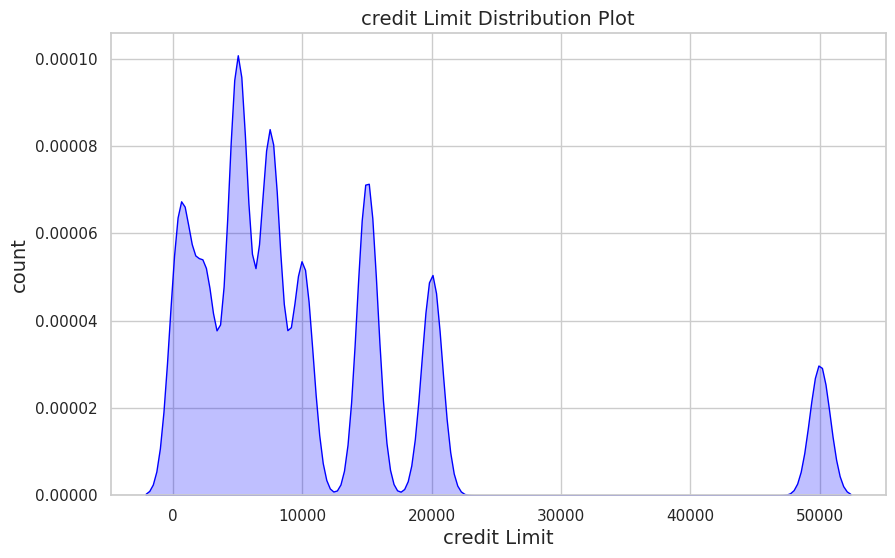

creditLimit
5000     127001
7500     105340
15000     91936
10000     67477
20000     64307
2500      59421
50000     38039
500       32751
1000      27861
250       27781
Name: count, dtype: int64


In [12]:
plot_distribution(df, "creditLimit")
print(df['creditLimit'].value_counts().head(15))

In [ ]:
''' 
Insights:

Distribusi data pada kolom 'creditLimit' cenderung skewed right (positively skewed) yang mana mayoritas data berada di bagian kiri dengan nilai yang lebih kecil, 
ini menunjukkan bahwa sebagian besar individu memiliki batas kredit yang relatif rendah. 
'''

### 2.1.2 availableMoney

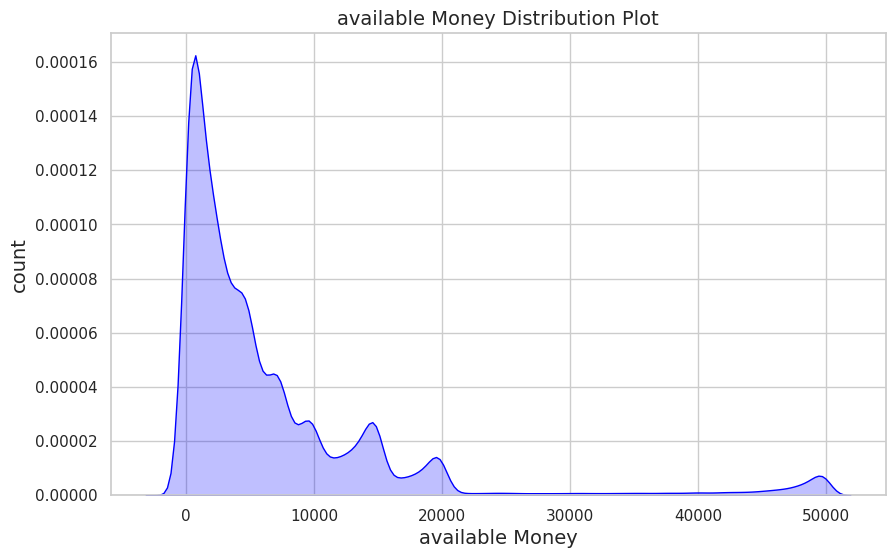

availableMoney
5000.00     5236
250.00      5119
7500.00     4309
15000.00    4239
500.00      3391
10000.00    2861
2500.00     2719
20000.00    2671
1000.00     1761
50000.00    1317
4993.97       15
460.59        15
228.63        15
214.29        15
7459.52       15
Name: count, dtype: int64
availableMoney
-4.14      4
-52.77     3
-2.32      2
-122.27    2
-66.38     2
-23.40     2
-231.29    2
-25.45     2
-84.47     2
-32.96     2
-29.47     2
-21.26     2
-85.51     2
-94.08     2
-45.79     2
Name: count, dtype: int64
Kolom availableMoney yang memiki nilai negatif ada sebanyak: 2611 dari total banyak row keseluruhan: 641914
Persentase: 0.41% dari jumlah seluruh row


In [13]:
plot_distribution(df, "availableMoney")
print(df['availableMoney'].value_counts().head(15))
negative_available_money = df[df['availableMoney'] < 0]
print(negative_available_money['availableMoney'].value_counts().head(15))
minus_available_money = negative_available_money.shape[0]
print("Kolom availableMoney yang memiki nilai negatif ada sebanyak: " + str(minus_available_money) + " dari total banyak row keseluruhan: " + str(df.shape[0]))
print("Persentase: " + str(round((minus_available_money/df.shape[0])*100, 2)) + "% dari jumlah seluruh row")

In [ ]:
''' 
Insights:

Distribusi data pada kolom 'availableMoney' cenderung skewed right (positively skewed) yang mana mayoritas data berada di bagian kiri dengan nilai yang lebih kecil,
ini menunjukkan bahwa sebagian besar individu memiliki uang yang tersedia relatif rendah. 
'''

### 2.1.3 transactionAmount

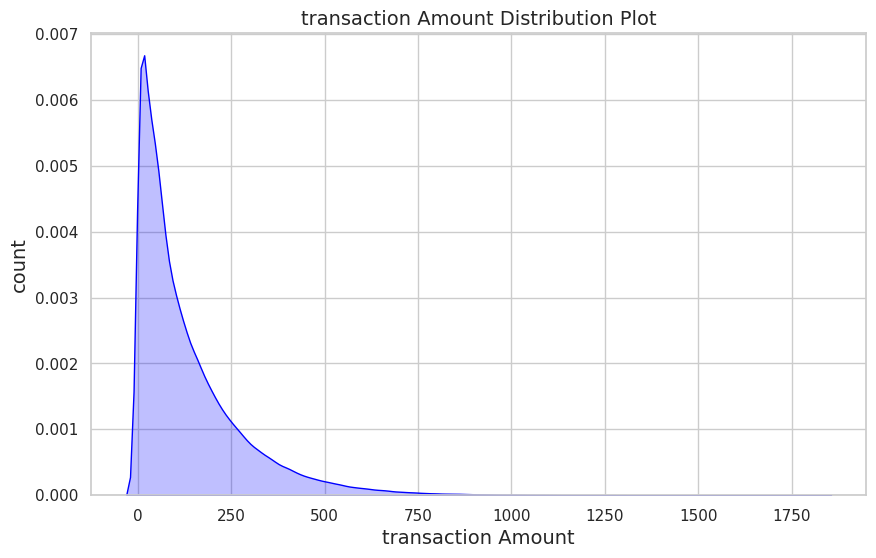

transactionAmount
0.00     18479
3.42       120
4.94       119
8.78       118
3.56       113
33.79      112
7.91       112
8.49       110
5.10       108
53.86      104
3.47       102
5.84       101
42.30      101
4.55       100
8.57        99
Name: count, dtype: int64
Nilai 0 yang ada pada 'transactionAmount' adalah: 18479 dari total banyak row keseluruhan: 641914
Persentase: 2.88% dari jumlah seluruh row


In [14]:
plot_distribution(df, "transactionAmount")
print(df['transactionAmount'].value_counts().head(15))
zero_value_transaction = df[df['transactionAmount'] == 0]
zero_value_transaction = zero_value_transaction.shape[0]
print("Nilai 0 yang ada pada 'transactionAmount' adalah: " + str(zero_value_transaction) + " dari total banyak row keseluruhan: " + str(df.shape[0]))
print("Persentase: " + str(round((zero_value_transaction/df.shape[0])*100, 2)) + "% dari jumlah seluruh row")

In [ ]:
''' 
Insights:

1. Distribusi data pada kolom 'transactionAmount' cenderung skewed right (positively skewed) yang mana mayoritas data berada di bagian kiri dengan nilai yang lebih kecil,
ini menunjukkan bahwa sebagian besar individu melakukan transaksi dengan jumlah yang relatif rendah.
2. Terdapat sejumlah transaksi dengan nilai 0 memiliki persentase yaitu sekitar 2.88% dari total transaksi,
walaupun persentasenya kecil dan memiliki jumlah count terbanyak bisa dikatakan angka 0 ini adalah hal yang lumrah pada kolom ini
karena menunjukkan adanya transaksi yang gagal atau tidak valid. 
'''

### 2.1.4 currentBalance

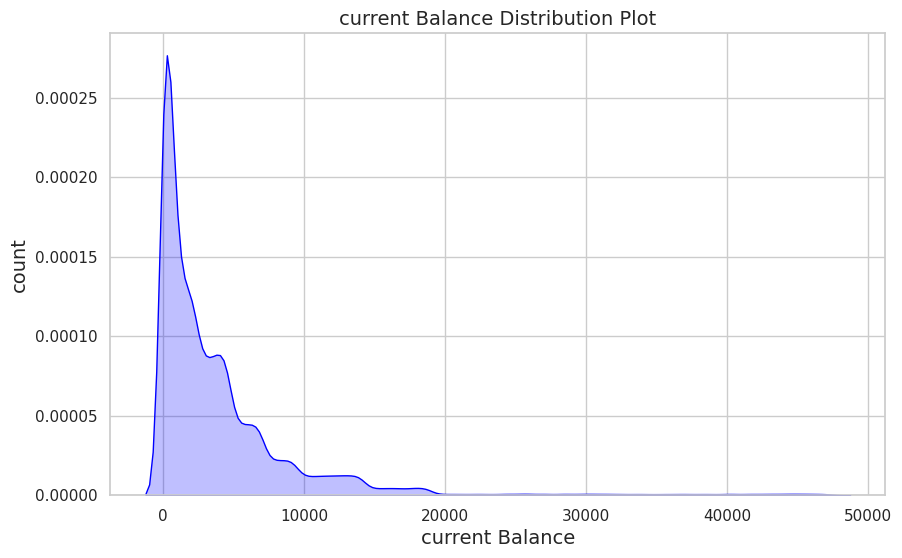

currentBalance
0.00     33622
53.52       21
40.48       19
45.53       18
53.86       18
21.37       17
6.96        16
6.24        16
6.03        16
29.72       16
63.01       16
14.52       15
5.33        15
35.71       15
7.67        15
Name: count, dtype: int64
Nilai 0 yang ada pada 'currentBalance' adalah: 33622 dari total banyak row keseluruhan: 641914
Persentase: 5.24% dari jumlah seluruh row


In [15]:
plot_distribution(df, "currentBalance")
print(df['currentBalance'].value_counts().head(15))
zero_current_balance = df[df['currentBalance'] == 0]
zero_current_balance = zero_current_balance.shape[0]
print("Nilai 0 yang ada pada 'currentBalance' adalah: " + str(zero_current_balance) + " dari total banyak row keseluruhan: " + str(df.shape[0]))
print("Persentase: " + str(round((zero_current_balance/df.shape[0])*100, 2)) + "% dari jumlah seluruh row")

In [ ]:
''' 
Insights: 

1. Distribusi data pada kolom 'availableMoney' cenderung skewed right (positively skewed) yang mana mayoritas data berada di bagian kiri dengan nilai yang lebih kecil, 
ini menunjukkan bahwa sebagian besar individu memiliki uang yang tersedia relatif rendah.

2. Terdapat nilai negatif pada kolom 'availableMoney' yang mana ada sebanyak 33622 row (5.24% dari total data) ini menunjukkan 
ada kemungkinan individu tersebut memiliki hutang atau overdraft pada akun mereka, angkata negatif ini bisa saja lumrah pada kolom ini 
karena bisa saja individu tersebut melakukan transaksi yang melebihi saldo yang tersedia (avaibleMoney).
'''

### 2.1.5 acqCountry

/tmp/ipykernel_6418/3432554630.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_, x=column_, palette="viridis", order=df_[column_].value_counts().index)


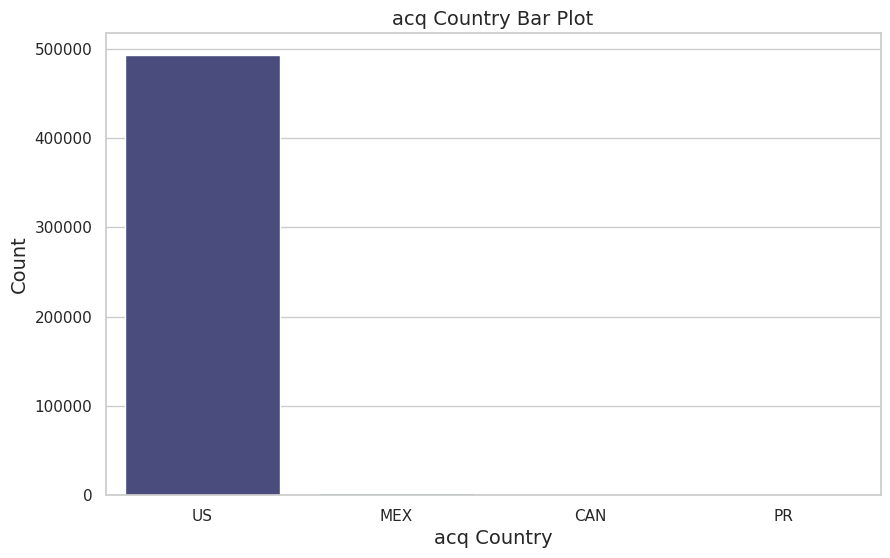

acqCountry
US     492814
MEX      2053
CAN      1434
PR        935
Name: count, dtype: int64


In [121]:
plot_bar(df, "acqCountry")
print(df['acqCountry'].value_counts())

### 2.1.5 acqCountry

/tmp/ipykernel_6418/3432554630.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_, x=column_, palette="viridis", order=df_[column_].value_counts().index)


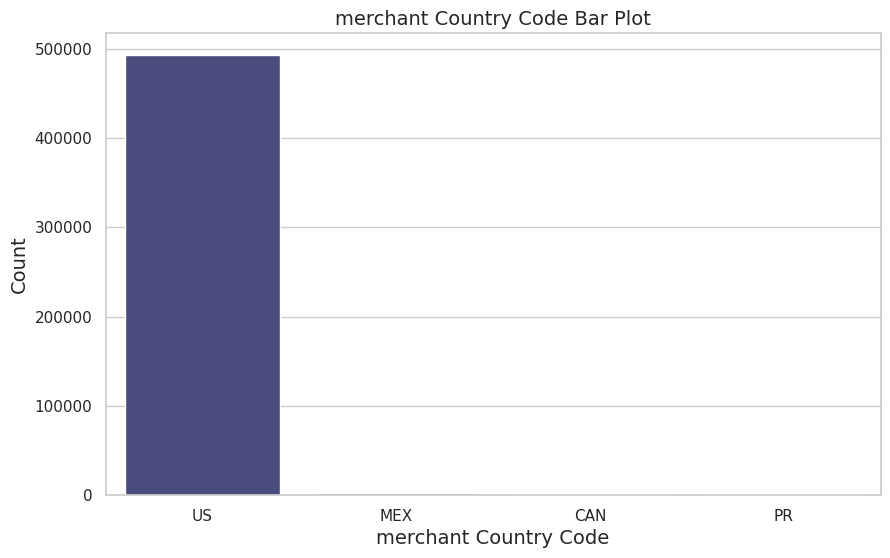

merchantCountryCode
US     492819
MEX      2052
CAN      1429
PR        936
Name: count, dtype: int64


In [122]:
plot_bar(df, "merchantCountryCode")
print(df['merchantCountryCode'].value_counts())

In [ ]:
''' 
Insight: 

Mayoritas transaksi dilakukan di negara 'US' (United States).
'''

### 2.1.6 merchantCategoryCode

/tmp/ipykernel_6418/3432554630.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_, y=column_, palette="viridis", order=df_[column_].value_counts().index)


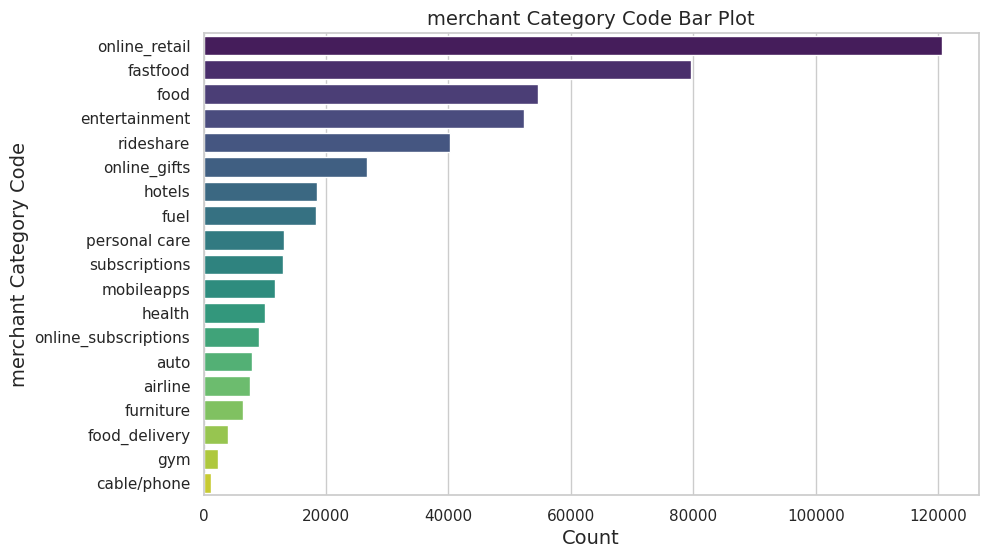

merchantCategoryCode
online_retail           120511
fastfood                 79608
food                     54582
entertainment            52285
rideshare                40225
online_gifts             26680
hotels                   18494
fuel                     18299
personal care            13130
subscriptions            12996
mobileapps               11705
health                   10087
online_subscriptions      9053
auto                      7855
airline                   7672
furniture                 6468
food_delivery             4001
gym                       2286
cable/phone               1299
Name: count, dtype: int64


In [123]:
plot_bar(df, "merchantCategoryCode", True)
print(df['merchantCategoryCode'].value_counts())

In [ ]:
''' 
Insight: 

Kategori merchant yang paling banyak digunakan untuk transaksi adalah 'online_retail' 
sedangkan kategori merchant yang paling sedikit digunakan adalah 'cable/phone'
''' 

### 2.1.7 expirationDateKeyInMatch

/tmp/ipykernel_6418/2101549325.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_, x=column_, palette="viridis")


expirationDateKeyInMatch
False    640945
True        969
Name: count, dtype: int64


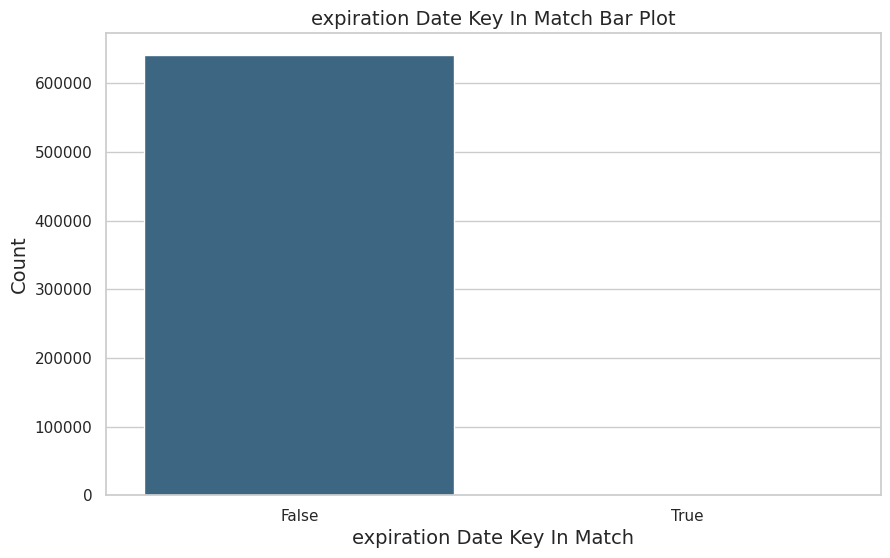

In [19]:
plot_bar(df, "expirationDateKeyInMatch")
print(df['expirationDateKeyInMatch'].value_counts())

In [ ]:
''' 
Insight: 

Tanggal kadaluarsa yang dimasukkan di sistem memiliki ketidakcocokan dengan tanggal kadaluarsa pada kartu kredit sebanyak 969 
sedangkan yang cocok ada sebanyak 640945, ini menunjukkan bahwa mayoritas tanggal kadaluarsa yang dimasukkan di sistem sudah benar. 
''' 

### 2.1.8 cardPresent

/tmp/ipykernel_6418/2101549325.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_, x=column_, palette="viridis")


cardPresent
False    340453
True     301461
Name: count, dtype: int64


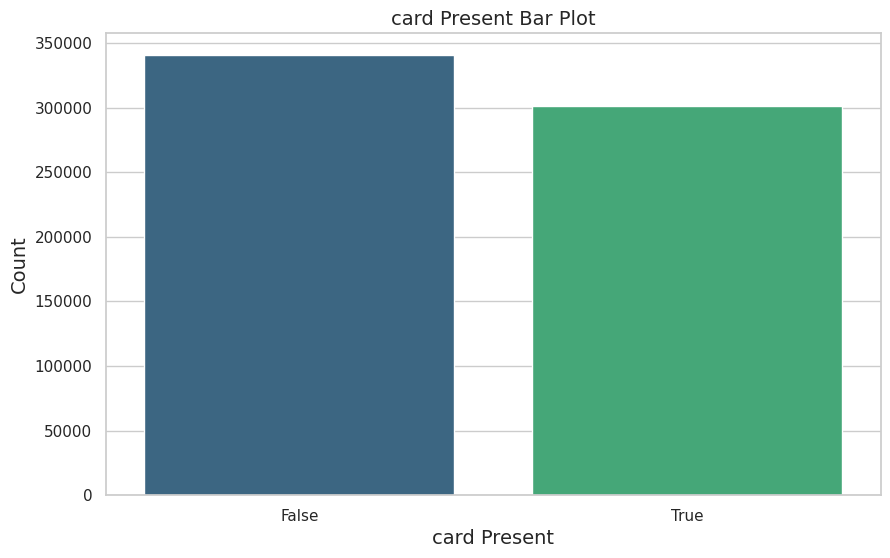

In [20]:
plot_bar(df, "cardPresent")
print(df['cardPresent'].value_counts())

In [ ]:
''' 
Insight: 

Terlihat bahwa mayoritas transaksi dilakukan dengan kartu yang tidak hadir (cardNotPresent). 
''' 

### 2.1.9 isFraud

/tmp/ipykernel_6418/2101549325.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_, x=column_, palette="viridis")


isFraud
False    630612
True      11302
Name: count, dtype: int64


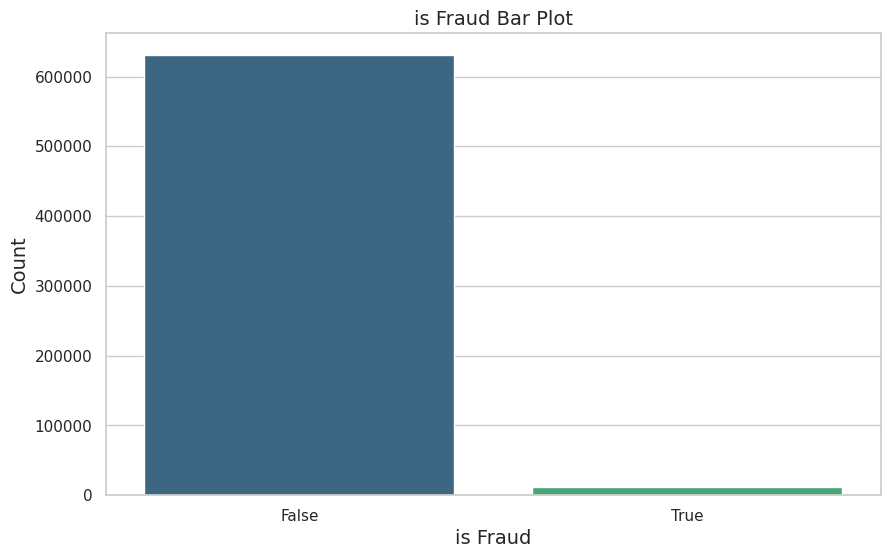

In [21]:
plot_bar(df, "isFraud")
print(df['isFraud'].value_counts())

In [ ]:
''' 
Insight: 

Mayoritas transaksi bukanlah transaksi penipuan (fraud) dengan jumlah 630612 dan penipuan ada sebanyak 11302 transaksi.
''' 

## 2.2 Bivariate Analysis

### 2.2.1 Correlation of Finance : creditLimit, availableMoney, transactionAmount, currentBalance

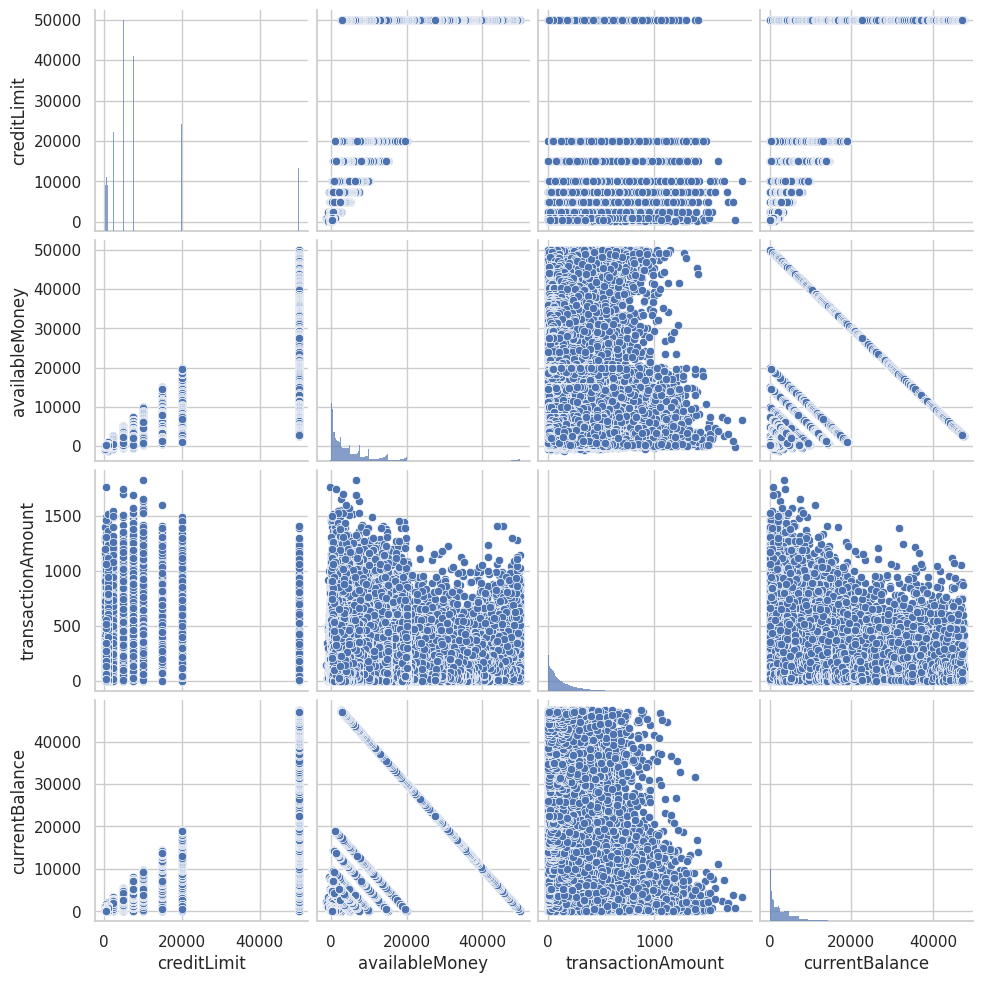

In [22]:
df_selected = df[['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']]
sns.pairplot(df_selected)
plt.show()

In [ ]:
''' 
Insights:

Terlihat ada korelasi positif yang kuat antara 'creditLimit', 'availableMoney' dan 'currentBalance'. 
Untuk membuktikannya bisa dilihat pada matriks korelasi heatmap di bawah ini. 
'''

Text(0.5, 1.0, 'Correlation Matrix Antar Variable')

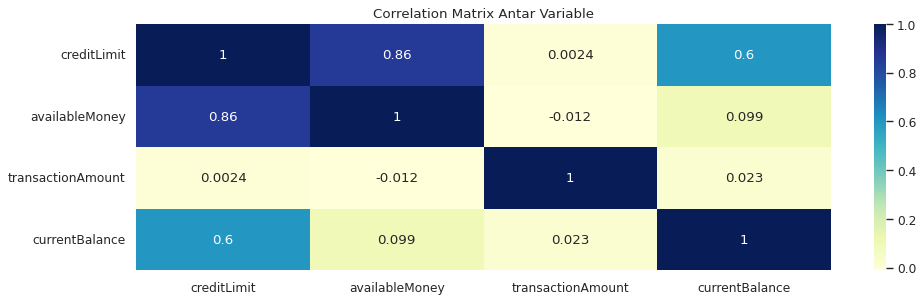

In [23]:
fig, ax = plt.subplots(figsize=(14,4), dpi=80)
sns.heatmap(df_selected.corr(), cmap="YlGnBu",annot=True)
plt.title('Correlation Matrix Antar Variable')

In [ ]:
''' 
Insights:

Pada korelasi headmap di atas didapatkan
1. Korelasi positif yang sangat kuat antara 'creditLimit' dan 'availableMoney' (0.86) ini menunjukkan bahwa semakin tinggi batas kredit seseorang,
semakin banyak uang yang tersedia untuk mereka gunakan.
2. Korelasi positif yang sangat kuat antara 'creditLimit' dan 'currentBalance' (0.60) ini menunjukkan bahwa individu dengan batas kredit yang lebih tinggi 
cenderung memiliki saldo akun yang lebih tinggi. 
3. Walaupun korelasi transactionAmount dengan ketiga kolom lainnya lemah, tetapi ini bisa menjadi indikasi bahwa jumlah transaksi tidak terlalu dipengaruhi oleh batas kredit, uang yang tersedia, atau saldo saat ini.
Dan bisa dianalisa lebih lanjut untuk mendapatkan insight yang lebih mendalam. 
'''

### 2.2.2 isFraud 

In [24]:
# Membuat fungsi plot untuk melihat hubungan antara kolom X dengan kolom isFraud 
def plot_fraud(y_column=''):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y=y_column, hue='isFraud', palette="viridis", order=df.groupby(y_column)['isFraud'].sum().sort_values(ascending=False).index[:30])
    plt.title(split_by_capital(y_column) + ' vs Is Fraud', fontsize=14)
    plt.xlabel('Count', fontsize=14)
    plt.ylabel(split_by_capital(y_column), fontsize=14)
    plt.legend(title='Is Fraud')
    plt.show()

    # Diurutkan berdasarkan jumlah fraud terbanyak
    fraud_counts = df.groupby(y_column)['isFraud'].value_counts().unstack(fill_value=0).sort_values(by=True, ascending=False)
    print(fraud_counts)


#### 2.2.2.1 isFraud vs merchantCountryCode

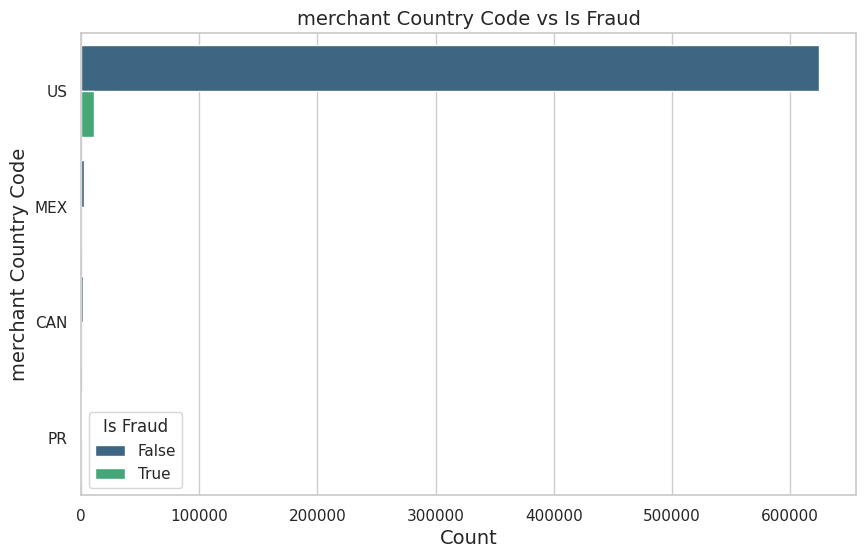

isFraud               False  True 
merchantCountryCode               
US                   624500  11077
MEX                    2577     59
CAN                    1821     53
PR                     1171     32


In [25]:
plot_fraud(y_column='merchantCountryCode')

#### 2.2.2.2 isFraud vs merchantCategoryCode

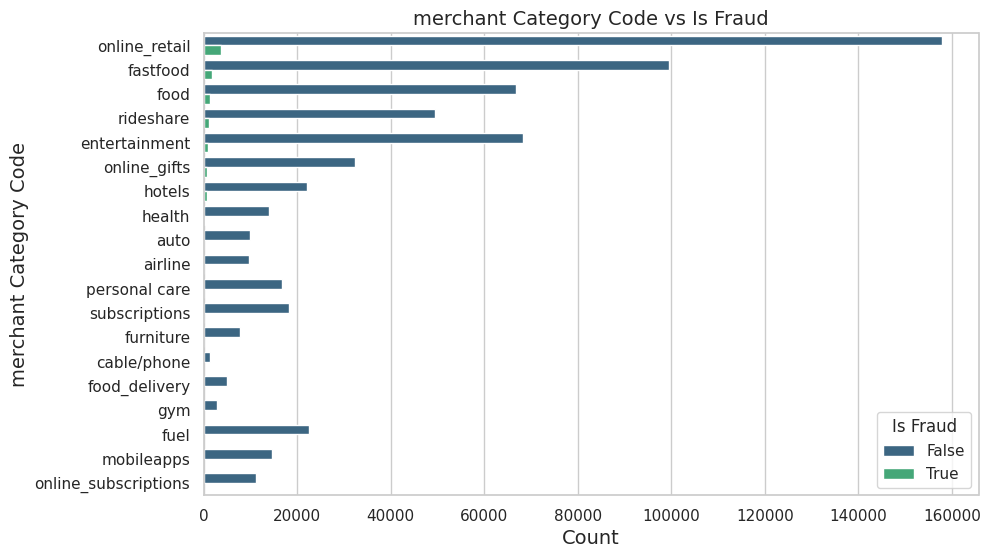

isFraud                False  True 
merchantCategoryCode               
online_retail         157822   3647
fastfood               99459   1737
food                   66855   1390
rideshare              49449   1125
entertainment          68210    928
online_gifts           32391    654
hotels                 22229    650
health                 14069    275
auto                    9936    211
airline                 9784    206
personal care          16713    204
subscriptions          18201    175
furniture               7713    100
cable/phone             1490      0
food_delivery           4990      0
gym                     2874      0
fuel                   22566      0
mobileapps             14614      0
online_subscriptions   11247      0


In [26]:
plot_fraud(y_column='merchantCategoryCode')

#### 2.2.2.3 isFraud vs transactionType

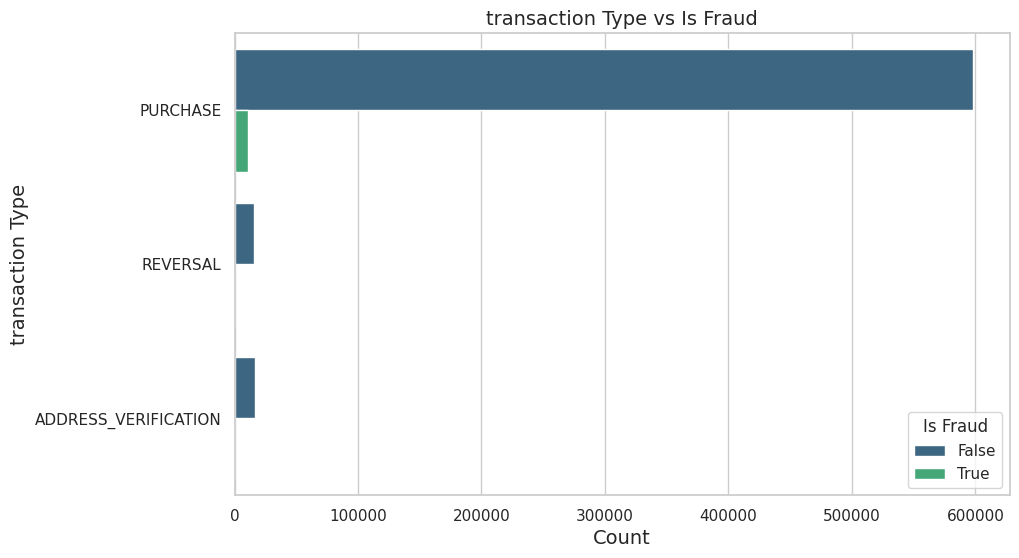

isFraud                False  True 
transactionType                    
PURCHASE              597775  10910
REVERSAL               15869    293
ADDRESS_VERIFICATION   16391     87


In [27]:
plot_fraud(y_column='transactionType')

#### 2.2.2.4 isFraud vs merchantName

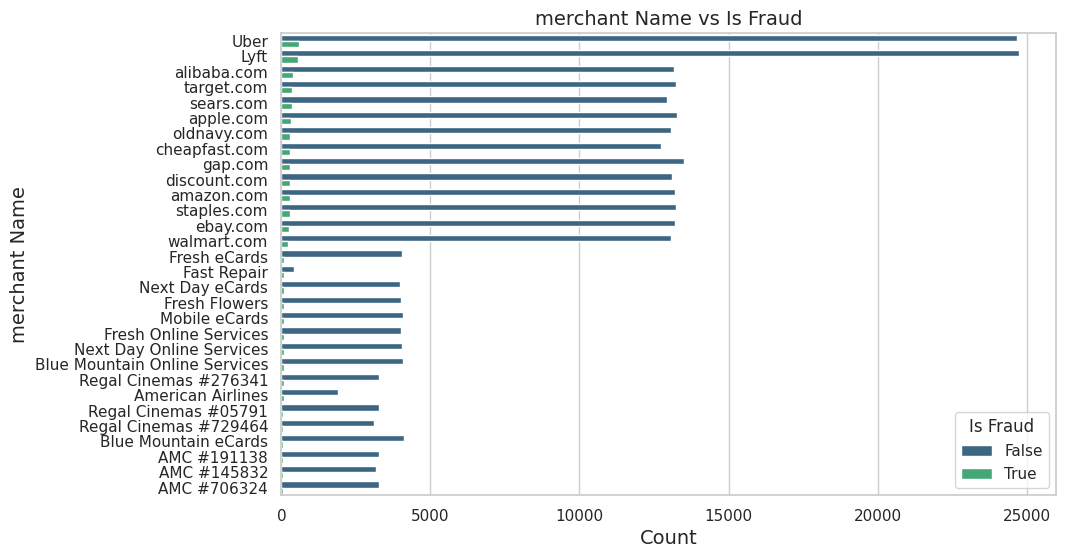

isFraud         False  True 
merchantName                
Uber            24688    575
Lyft            24761    550
alibaba.com     13178    405
target.com      13243    358
sears.com       12931    348
...               ...    ...
Arbys #149797      83      0
Arbys #384282      80      0
Arbys #679319      66      0
Arbys #742978      86      0
Wendys #974901     86      0

[2493 rows x 2 columns]


In [28]:
plot_fraud(y_column='merchantName')

In [ ]:
''' 
Insights:

1. Negara dengan jumlah transaksi penipuan (isFraud) terbanyak adalah 'US' (United States).
2. Kategori merchant dengan jumlah transaksi penipuan (isFraud) terbanyak adalah 'online_retail'.
3. Tipe transaksi dengan jumlah penipuan (isFraud) terbanyak adalah 'purchase'.
4. Merchant dengan jumlah transaksi penipuan (isFraud) terbanyak adalah 'UBER'.
'''

## 2.3 Multivariate Analysis

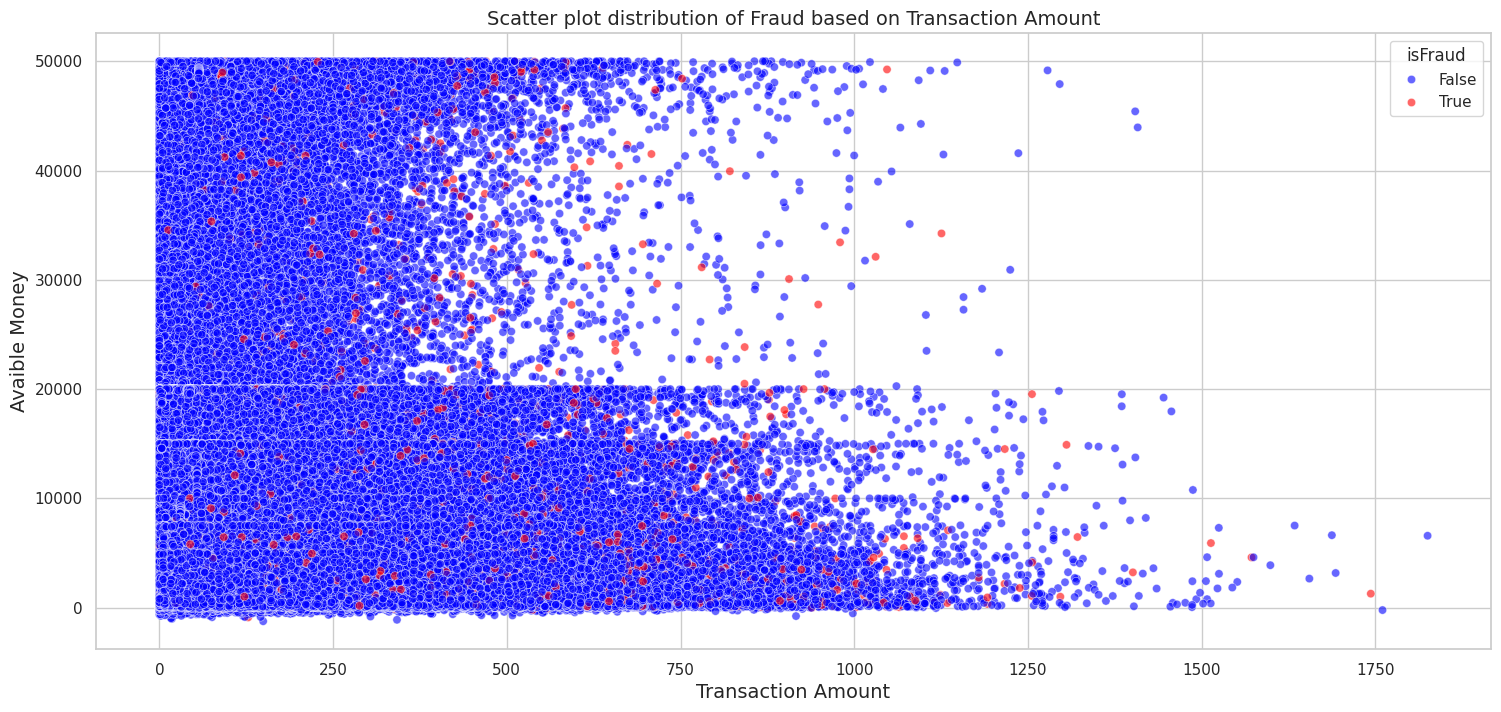

In [29]:
plt.figure(figsize=(18,8))
sns.scatterplot(x=df['transactionAmount'], y=df['availableMoney'], hue=df['isFraud'], palette=['blue','red'], alpha=0.6)
plt.title("Scatter plot distribution of Fraud based on Transaction Amount",fontsize=14)
plt.xlabel("Transaction Amount", fontsize=14)
plt.ylabel("Avaible Money", fontsize=14)
plt.show()

In [ ]:
''' 
Insights:

Pola fraud walau belum terlalu jelas, tapi terlihat bahwa fraud cenderung terjadi pada avaible money yang rendah (di bawah 2000) dan transaction amount (di bawah 1000). 
Perlu dianalisa lebih lanjut untuk mendapatkan insight yang lebih mendalam.
'''

# 3. Data Proprocessing

## 3.1 Handling Duplicate Values

In [30]:
df.duplicated().sum()

np.int64(0)

In [31]:
'''
Insight: 

Tidak ada duplikasi pada dataset ini.
'''

'\nInsight: \n\nTidak ada duplikasi pada dataset ini.\n'

## 3.2 Handling Missing Values

In [32]:
df.isnull().sum()

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  3913
merchantCountryCode          624
posEntryMode                3345
posConditionCode             287
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              589
isFraud                        0
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
dtype: int64

In [33]:
'''
Insight: 

Data missing tidak lebih banyak dari 5% total row -> akan dilakukan cleaning data penghapusan row. 
'''

'\nInsight: \n\nData missing tidak lebih banyak dari 5% total row -> akan dilakukan cleaning data penghapusan row. \n'

In [34]:
df.dropna(inplace=True)
print(df.isnull().sum())
print(df.shape)

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
isFraud                     0
currentBalance              0
cardPresent                 0
expirationDateKeyInMatch    0
dtype: int64
(633846, 23)


## 3.3 Handling Outliers
Karena K-Means sensitif dengan outliers maka menghilangkan outliers wajib dilakukan

In [35]:
def plot_bloxplot(column_=""):
    sns.boxplot(df[column_])
    plt.title(split_by_capital(column_) + " Box Plot")
    plt.ylabel(split_by_capital(column_))
    plt.show()

In [65]:
def remove_outliers(df_, column_=""):
    Q1 = df_[column_].quantile(0.25)
    Q3 = df_[column_].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"Lower Bound for {column_}: {lower_bound}")
    print(f"Upper Bound for {column_}: {upper_bound}")
    
    outliers = df_[(df_[column_] < lower_bound) | (df_[column_] > upper_bound)]
    print(f"Outliers for {column_}:\n{outliers}")
    
    df_.drop(outliers.index, inplace=True)


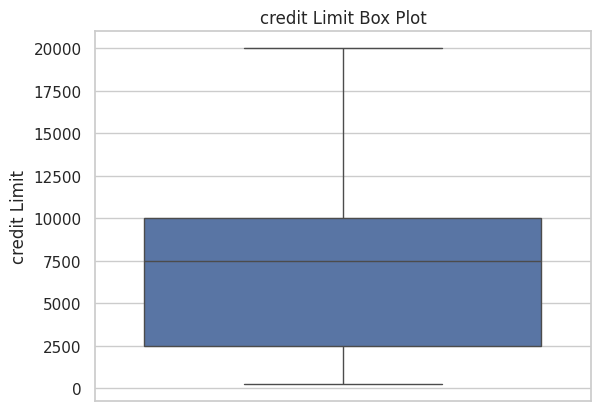

In [68]:
plot_bloxplot("creditLimit")

In [ ]:
''' 
Insights:

Tidak terjadi outlier pada kolom 'creditLimit'
'''

In [66]:
remove_outliers(df, "creditLimit")

Lower Bound for creditLimit: -8750.0
Upper Bound for creditLimit: 21250.0
Outliers for creditLimit:
Empty DataFrame
Columns: [accountNumber, customerId, creditLimit, availableMoney, transactionDateTime, transactionAmount, merchantName, acqCountry, merchantCountryCode, posEntryMode, posConditionCode, merchantCategoryCode, currentExpDate, accountOpenDate, dateOfLastAddressChange, cardCVV, enteredCVV, cardLast4Digits, transactionType, isFraud, currentBalance, cardPresent, expirationDateKeyInMatch]
Index: []

[0 rows x 23 columns]


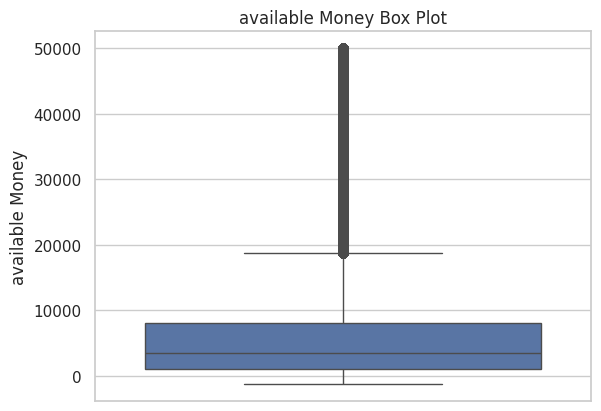

In [37]:
plot_bloxplot("availableMoney")

In [ ]:
''' 
Insights:

Terjadi outlier pada kolom 'availableMoney', perlu dilakukan pembersihan data untuk menghapus outlier tersebut.
'''

In [67]:
# Dilakukan penghapusan outlier pada kolom 'availableMoney'
remove_outliers(df, "availableMoney")

Lower Bound for availableMoney: -7359.455000000002
Upper Bound for availableMoney: 14815.945000000002
Outliers for availableMoney:
        accountNumber  customerId  creditLimit  availableMoney  \
1702        782400169   782400169        15000        15000.00   
1703        782400169   782400169        15000        14998.44   
3064        648518770   648518770        15000        15000.00   
3065        648518770   648518770        15000        14975.37   
3182        206257508   206257508        15000        15000.00   
...               ...         ...          ...             ...   
639703      180409767   180409767        15000        15000.00   
639704      180409767   180409767        15000        14938.51   
639705      180409767   180409767        15000        15000.00   
639706      180409767   180409767        15000        14847.87   
639765      665147073   665147073        15000        15000.00   

        transactionDateTime  transactionAmount  \
1702    2016-01-02T22:52:5

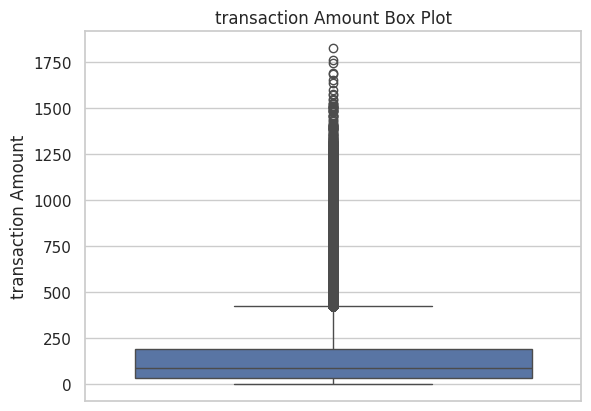

In [38]:
plot_bloxplot("transactionAmount")

In [ ]:
''' 
Insights:

Terjadi outlier pada kolom 'transactionAmount', perlu dilakukan pembersihan data untuk menghapus outlier tersebut.
'''

In [69]:
# Dilakukan penghapusan outlier pada kolom 'transactionAmount'
remove_outliers(df, "transactionAmount")

Lower Bound for transactionAmount: -202.95
Upper Bound for transactionAmount: 425.28999999999996
Outliers for transactionAmount:
        accountNumber  customerId  creditLimit  availableMoney  \
21          733493772   733493772         5000         3488.04   
22          733493772   733493772         5000         3020.16   
49          733493772   733493772         5000         1241.65   
80          733493772   733493772         5000         2394.36   
84          733493772   733493772         5000         1576.12   
...               ...         ...          ...             ...   
641613      877651598   877651598         7500         7333.95   
641865      186770399   186770399         7500         7377.86   
641872      186770399   186770399         7500         6287.79   
641892      186770399   186770399         7500         4855.72   
641906      186770399   186770399         7500         3466.22   

        transactionDateTime  transactionAmount              merchantName  \
21

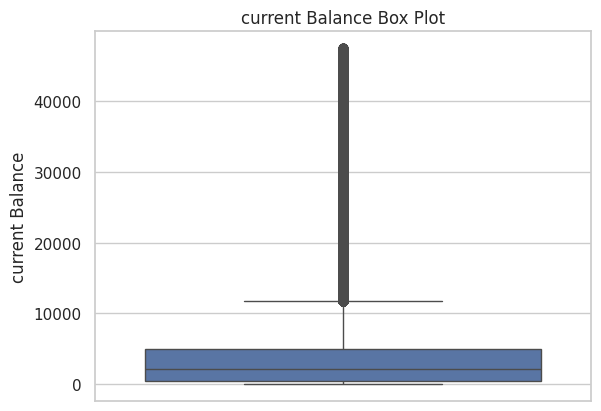

In [39]:
plot_bloxplot("currentBalance")

In [70]:
# Dilakukan penghapusan outlier pada kolom 'currentBalance'
remove_outliers(df, "currentBalance")

Lower Bound for currentBalance: -5892.121249999999
Upper Bound for currentBalance: 11244.368749999998
Outliers for currentBalance:
        accountNumber  customerId  creditLimit  availableMoney  \
1774        782400169   782400169        15000         3522.67   
1775        782400169   782400169        15000         3501.69   
1776        782400169   782400169        15000         3391.07   
1777        782400169   782400169        15000         3347.42   
1778        782400169   782400169        15000         3180.18   
...               ...         ...          ...             ...   
638758      960595211   960595211        15000         1411.98   
638759      960595211   960595211        15000         1385.37   
638760      960595211   960595211        15000         1316.16   
638761      960595211   960595211        15000         1261.96   
638762      960595211   960595211        15000         1207.76   

        transactionDateTime  transactionAmount         merchantName  \
1774 

In [ ]:
''' 
Insights:

Terjadi outlier pada kolom 'currentBalance', perlu dilakukan pemberihan data untuk menghapus outlier tersebut.
'''

## 3.4 Data Transfromation
Normalisasi perlu dilakukan karena K-Means sensitif pada: 
1. non-numberik (K-means tidak bisa mengolah data kategorikal)
2. keseimbangan data (contoh jika pada kolom X rentang data jutaan dan kolom y rentangnya ribuan maka K-Means akan cenderung lebih memprioritaskan kolom X)

In [162]:
#Mengubah kategorikal (Boolean) menjadi numerikal (0 atau 1)
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
df['isFraud'] = le.fit_transform(df['isFraud'])
df['cardPresent'] = le.fit_transform(df['cardPresent'])
df['expirationDateKeyInMatch'] = le.fit_transform(df['expirationDateKeyInMatch'])
df.head()

accountNumber  customerId  creditLimit  availableMoney  \
0      733493772   733493772         5000         5000.00   
1      733493772   733493772         5000         4888.67   
2      733493772   733493772         5000         4863.92   
3      733493772   733493772         5000         4676.52   
4      733493772   733493772         5000         4449.18   

   transactionDateTime  transactionAmount merchantName acqCountry  \
0  2016-01-08T19:04:50             111.33         Lyft         US   
1  2016-01-09T22:32:39              24.75         Uber         US   
2  2016-01-11T13:36:55             187.40         Lyft         US   
3  2016-01-11T22:47:46             227.34         Lyft         US   
4  2016-01-16T01:41:11               0.00         Lyft         US   

  merchantCountryCode  posEntryMode  ...  accountOpenDate  \
0                  US           5.0  ...         3/8/2014   
1                  US           9.0  ...         3/8/2014   
2                  US           5.0  ...         3/8/2014   
3                  US           2.0  ...         3/8/2014   
4                  US           2.0  ...         3/8/2014   

  dateOfLastAddressChange cardCVV enteredCVV cardLast4Digits  \
0                3/8/2014     492        492            9184   
1                3/8/2014     492        492            9184   
2                3/8/2014     492        492            9184   
3                3/8/2014     492        492            9184   
4                3/8/2014     492        492            9184   

        transactionType  isFraud  currentBalance cardPresent  \
0              PURCHASE        1            0.00           0   
1              PURCHASE        0          111.33           0   
2              PURCHASE        0          136.08           0   
3              PURCHASE        1          323.48           0   
4  ADDRESS_VERIFICATION        0          550.82           0   

   expirationDateKeyInMatch  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  

[5 rows x 23 columns]

In [72]:
# Menormalisasi data numerik agar data lebih seimbang antar kolom (feature scaling) yang mana membuat data lebih optimal diolah oleh Clustering K-Means
# Karena K-Means sangat sensitif terhadap skala data

from sklearn.preprocessing import StandardScaler

finance_df = df[['isFraud', 'creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']]
print(finance_df.head())

# 1. Inisialisasi Scaler
scaler = StandardScaler()

# 2. Lakukan scaling pada data
scaled_features = scaler.fit_transform(finance_df)

# 3. Buat DataFrame baru dari data yang sudah di-scale
finance_df_scaled = pd.DataFrame(scaled_features, columns=finance_df.columns)

print("\nData setelah di-scaling (5 baris pertama):")
finance_df_scaled.head()

   isFraud  creditLimit  availableMoney  transactionAmount  currentBalance
0        1         5000         5000.00             111.33            0.00
1        0         5000         4888.67              24.75          111.33
2        0         5000         4863.92             187.40          136.08
3        1         5000         4676.52             227.34          323.48
4        0         5000         4449.18               0.00          550.82

Data setelah di-scaling (5 baris pertama):


isFraud  creditLimit  availableMoney  transactionAmount  currentBalance
0  7.961394    -0.371602        0.236031           0.001775       -1.026311
1 -0.125606    -0.371602        0.207716          -0.848495       -0.984975
2 -0.125606    -0.371602        0.201422           0.748830       -0.975785
3  7.961394    -0.371602        0.153761           1.141066       -0.906205
4 -0.125606    -0.371602        0.095943          -1.091556       -0.821795

# 4. Data Clustering

## 4.1 Menentukan banyak Cluster dengan Metode Elbow

In [73]:
inertia_values = []
k_ranges = range(1, 11)

for k in k_ranges:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(finance_df_scaled)
    inertia_values.append(kmeans.inertia_)

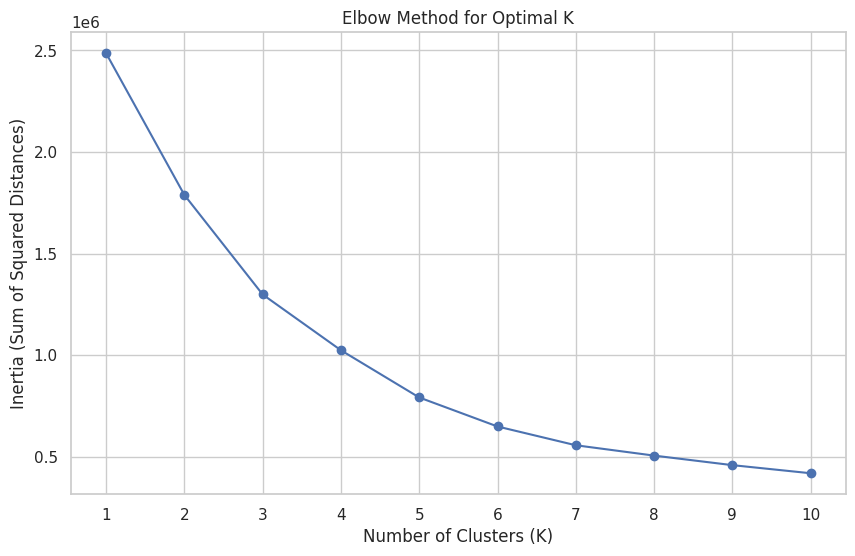

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(k_ranges, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(k_ranges)
plt.grid(True)
plt.show()

In [75]:
# Menentukan jumlah cluster
kmeans = KMeans(n_clusters=5)

kmeans_label = kmeans.fit_predict(finance_df)

In [76]:
kmeans_label

array([2, 2, 2, ..., 4, 4, 4], shape=(497236,), dtype=int32)

In [77]:
finance_df["cluster"] = kmeans_label

/tmp/ipykernel_6418/1822325336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finance_df["cluster"] = kmeans_label


In [78]:
# df_clean_clust_0 = finance_df[finance_df.cluster == 0]

## 4.2 Ploting Hasil Clustering

In [81]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(finance_df)

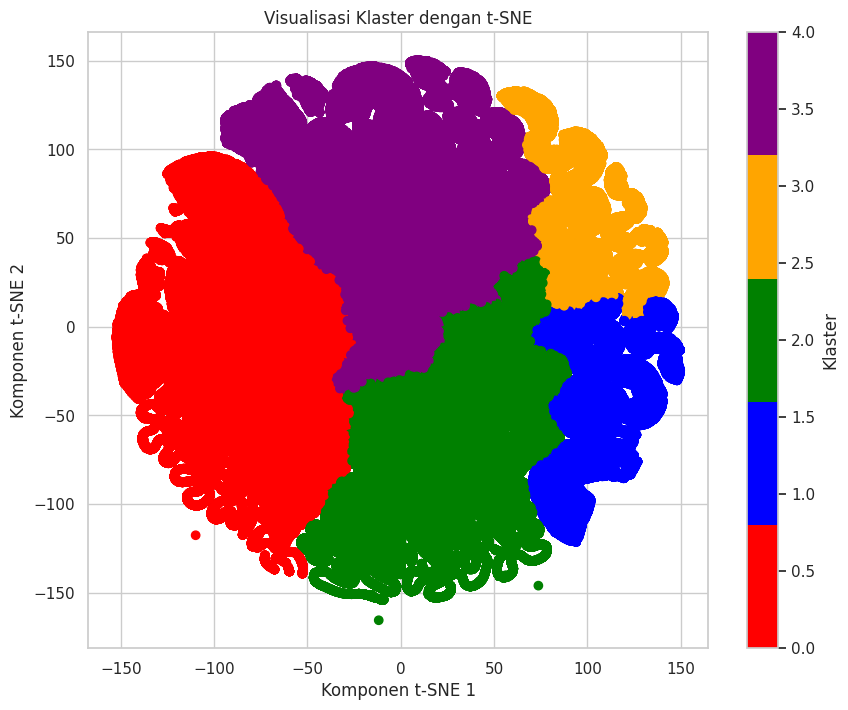

In [103]:
from matplotlib.colors import ListedColormap  

palette = ['red', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_2d[:, 0], 
    X_2d[:, 1], 
    c=kmeans_label, 
    cmap=ListedColormap(palette) 
)
plt.title('Visualisasi Klaster dengan t-SNE')
plt.xlabel('Komponen t-SNE 1')
plt.ylabel('Komponen t-SNE 2')
plt.colorbar(scatter, label='Klaster')  # legenda warna
plt.grid(True)
plt.show()

In [ ]:
''' 
Insights:

Dari visualisasi t-SNE di atas, terlihat bahwa ada beberapa klaster yang terbentuk dengan baik,
tapi perlu dilakukan pengecekan kualitas clustering  lebih lanjut untuk memastikan validitasnya. 
'''

## 4.3 Implementasi Clustering pada availableMoney vs. transactionAmount

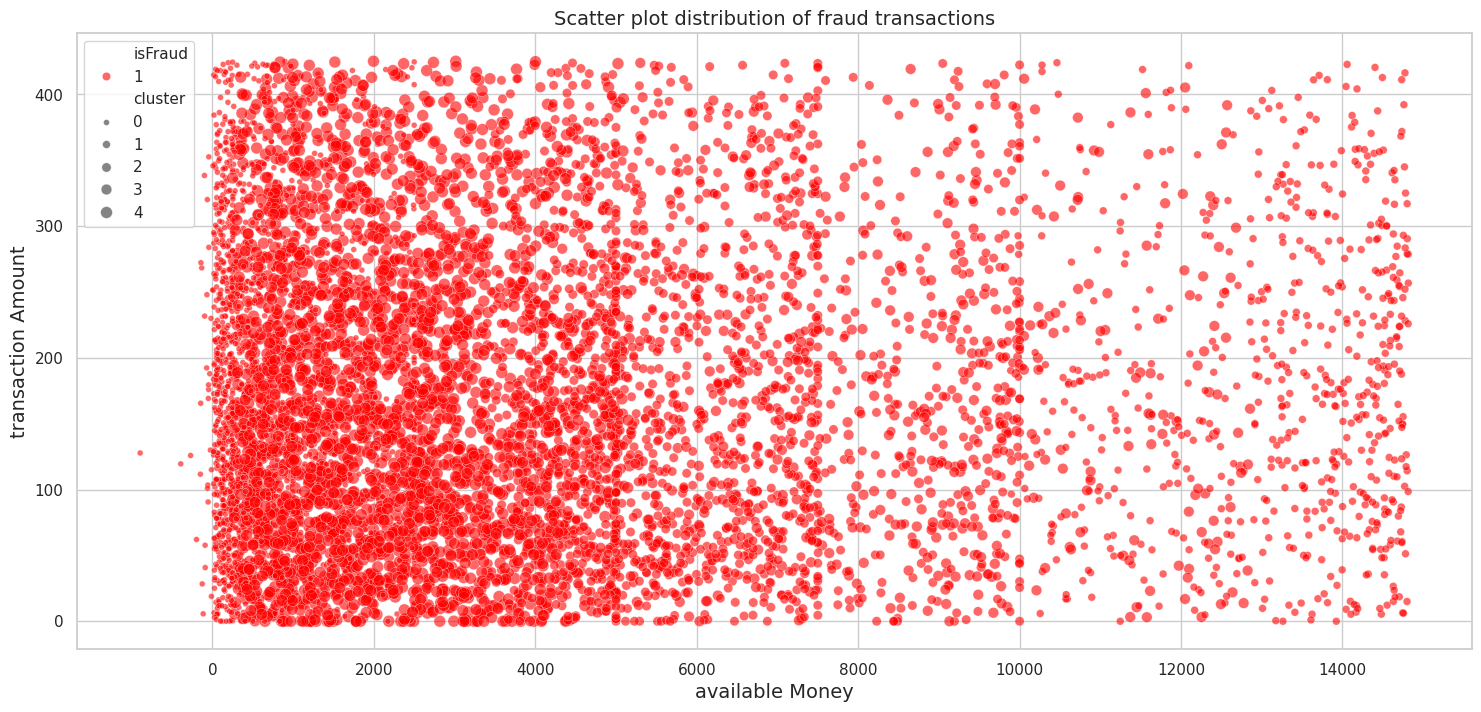

In [127]:
filtered_df = finance_df[finance_df['isFraud'] == 1]

plt.figure(figsize=(18,8))
sns.scatterplot(
    x=filtered_df['availableMoney'], 
    y=filtered_df['transactionAmount'], 
    size=filtered_df['cluster'], 
    hue=filtered_df["isFraud"], 
    palette=['red'],  # Warna untuk isFraud == 1
    alpha=0.6
)
plt.title("Scatter plot distribution of fraud transactions", fontsize=14)
plt.xlabel("available Money", fontsize=14)
plt.ylabel("transaction Amount", fontsize=14)
plt.show()

In [ ]:
''' 
Insight: 

Terlihat banyaknya fraud terjadi pada pojok kiri bawah chart karena banyak berkumpul pola di sana, tapi masih belum jelas perlu dilakukan perjelasan visual.
'''

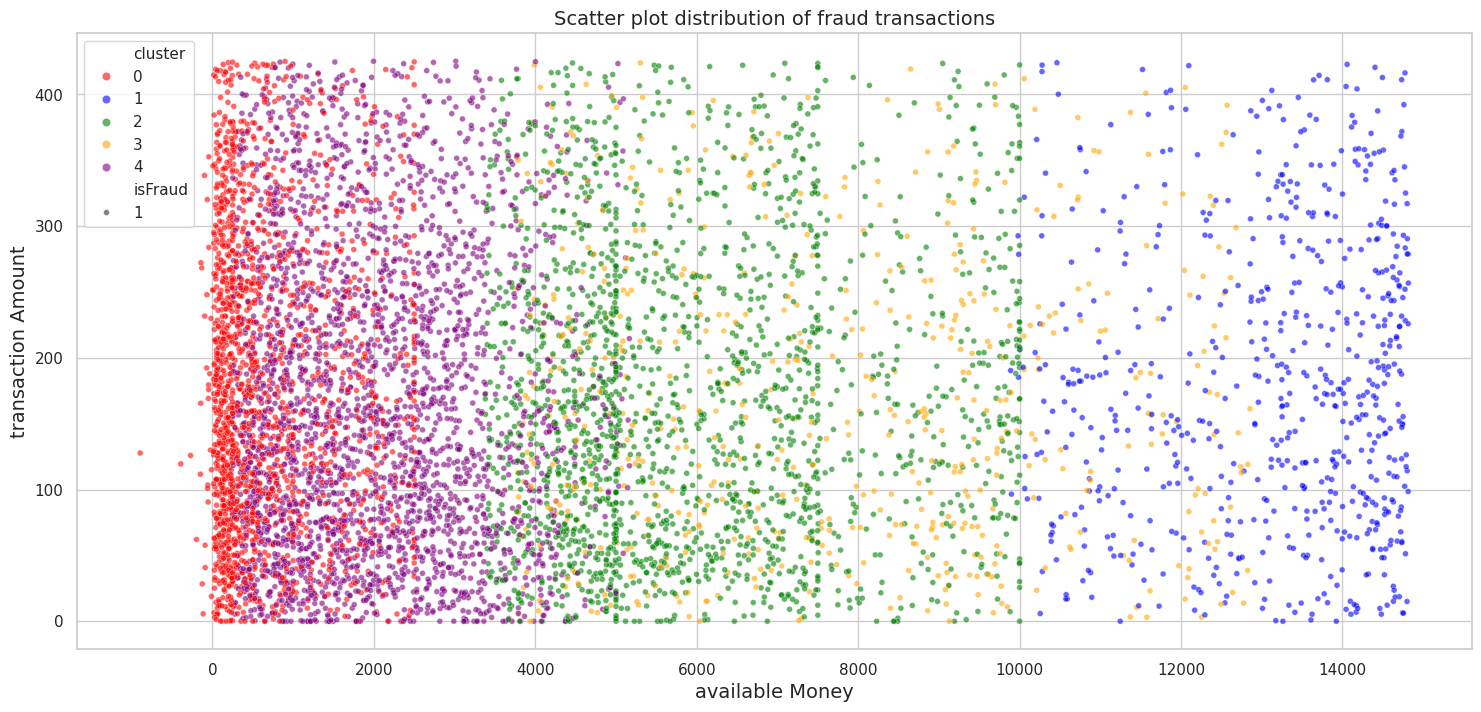

In [129]:
plt.figure(figsize=(18,8))
sns.scatterplot(
    x=filtered_df['availableMoney'], 
    y=filtered_df['transactionAmount'], 
    size=filtered_df['isFraud'], 
    hue=filtered_df["cluster"], 
    palette=['red', 'blue', 'green', 'orange', 'purple'], 
    alpha=0.6
)
plt.title("Scatter plot distribution of fraud transactions", fontsize=14)
plt.xlabel("available Money", fontsize=14)
plt.ylabel("transaction Amount", fontsize=14)
plt.show()

In [115]:
# Hitung jumlah data per cluster
cluster_counts = filtered_df["cluster"].value_counts()
print("Jumlah data per cluster:")
print(cluster_counts)

Jumlah data per cluster:
cluster
4    2744
2    1909
0    1823
1     659
3     588
Name: count, dtype: int64


In [124]:
''' 
Insight: 

Terlihat cluster yang paling banyak terjadi Fraud ada pada cluster 4 disusul oleh cluster 2 dan cluster 0. Untuk cluster 1 dan 3 memiliki jarak yang cukup jauh dari ketiga cluster terbanyak (0,4,2). 
Yang mana Fraud cenderung terjadi pada pada cluster yang memiliki avaibleMoney dan transactionAmount yang kecil.

Karena jarak banyak Fraud yang cukup signifikan antara Cluster 0,2,4 dengan 1,3 maka peneliti membuat 2 kelompok baru yaitu: 
1. Kelompok MajorityFarud yaitu merupakan Cluster: 0,2,4
2. Kelompok MinorityFraud yaitu merupakan Cluster: 1,3

Terlihat pula pola pada Kelompok MajorityFraud merupakan kelompok yang mana memiliki avaibleMoney yang lebih sedikit daripada Kelompok MinorityFraud
Peneliti menduga penipuan banyak terjadi pada akun kredit yang memiliki saldo yang rendah -> perlu dilakukan pembuatan Hipotesis Alternatid dan pembuktian Hipoteses.
'''

' \nInsight: \n\nTerlihat cluster yang paling banyak terjadi Fraud ada pada cluster 4 disusul oleh cluster 2 dan cluster 0. Untuk cluster 1 dan 3 memiliki jarak yang cukup jauh dari ketiga cluster terbanyak. \nKarena jarak yang cukup signifikan antara Cluster 0,2,4 dengan 1,3 maka peneliti membuat 2 kelompok baru yaitu: \nYang mana Fraud cenderung terjadi pada pada cluster yang memiliki avaibleMoney dan transactionAmount yang kecil.\n'

## 4.4 Hipotesis

### 4.4.1 Hipotesis X1
- H0: Persebaran Fraud terjadi sama antara ekonomi kelas bawah (avaibleMoney rendah) maupun ekonomi kelas atas (avaibleMoney tinggi)
- H1: Fraud mayoritas terjadi pada kalangan ekonomi kelas bawah (avaibleMoney rendah)

In [119]:
# Hitung nilai maksimum dan minimum untuk kolom X (availableMoney) dan Y (transactionAmount)
cluster_stats = filtered_df.groupby("cluster").agg({
    "availableMoney": ["max", "min", "mean", "median"], 
    "transactionAmount": ["max", "min", "mean", "median"]
})

cluster_statscluster_stats_sorted = cluster_stats.sort_values(by=('availableMoney', 'mean'), ascending=True)
print("\nStatistik maksimum dan minimum untuk setiap cluster, diurutkan berdasarkan availableMoney:")
cluster_statscluster_stats_sorted



Statistik maksimum dan minimum untuk setiap cluster, diurutkan berdasarkan availableMoney:


availableMoney                                   transactionAmount  \
                   max      min          mean     median               max   
cluster                                                                      
0              2500.00  -894.64    677.674723    434.210            425.06   
4              5166.77   251.15   2068.348397   1959.575            425.22   
2             10000.00  3381.34   6043.785029   5629.170            423.90   
3             12854.70  3771.87   7642.391088   7385.305            423.96   
1             14815.69  9889.41  13095.571062  13430.590            424.11   

                                  
         min        mean  median  
cluster                           
0        0.0  177.756429  162.07  
4        0.0  166.711006  148.71  
2        0.0  171.465610  156.62  
3        0.0  171.983333  156.79  
1        0.0  182.659272  172.18

In [ ]:
''' 
Insights:

Dapat dilihat pada tabel di atas bahwa:
1. Cluster 0, 2, dan 4 (MajorityFraud)) memiliki rata-rata availableMoney yang lebih rendah dibandingkan dengan Cluster Cluster 1 dan 3 (MinorityFraud).
Ini menunjukkan bahwa penipuan (fraud) cenderung terjadi pada akun dengan saldo yang lebih rendah.

2. Cluster 1 dan 3 (MinorityFraud) memiliki rata-rata transactionAmount yang lebih tinggi dibandingkan dengan Cluster 0, 2, dan 4 (MajorityFraud). 
Walau ada ketidaksesuaian pada cluster 0 dan hasil yang tipis pada cluster 2 dan 3, tapi terlihat perbedaan yang cukup signifikan pada cluster 1 dan 4.
'''

Kesimpulan Hipotesis 4.4.1 : Menolak hipotesis H0, fraud banyak terjadi kalangan ekonomi kelas bawah (avaibleMoney rendah)

In [ ]:
''' 
Karena hasil kesimpulan Hipotesis 4.4.1 masih bias karena ada kemungkinan banyaknya fraud terjadi pada akun dengan saldo rendah
karena banyaknya akun dengan saldo rendah pada dataset ini yang mana terbukti pada analisis univariat sebelumnya bahwa avaibleMoney cenderung skewed right (positively skewed),
maka perlu dilakukan uji Hipotesis statistik untuk membuktikan Hipotesis tersebut yang mana dilakukan pada 4.4.2 Hipotesis X2.
'''

### 4.4.2 Hipotesis X2
- H0: Tidak ada hubungan antara grup ekonomi (berdasarkan klaster) dan kejadian fraud.
- H1: Terdapat hubungan signifikan antara grup ekonomi dan kejadian fraud.

In [161]:
from scipy.stats import chi2_contingency
# 1. Buat grup berdasarkan hipotesis
low_economy_clusters = [0, 2, 4]
high_economy_clusters = [1, 3]

# Buat kolom baru untuk menandai grup setiap transaksi
def assign_group(cluster):
    if cluster in low_economy_clusters:
        return 'Grup Ekonomi Rendah'
    elif cluster in high_economy_clusters:
        return 'Grup Ekonomi Tinggi'
    return 'Lainnya'

finance_df['economy_group'] = finance_df['cluster'].apply(assign_group)

# 2. Buat Tabel Kontingensi
# Tabel ini akan menghitung jumlah fraud vs non-fraud untuk setiap grup
contingency_table = pd.crosstab(finance_df['economy_group'], finance_df['isFraud'])
    
print("--- Tabel Kontingensi (Jumlah Kejadian) ---")
print(contingency_table)
print("\n" + "="*45 + "\n")


# 3. Lakukan Uji Chi-Square
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# 4. Menyajikan ringkasan statistik
summary_df = finance_df.groupby(['economy_group', 'isFraud']).size().unstack(fill_value=0)
# Hitung total transaksi per grup
summary_df['total'] = summary_df.sum(axis=1)
# Hitung persentase fraud (jika ada kolom True)
if True in summary_df.columns:
    summary_df['persentase_fraud (%)'] = (summary_df[True] / summary_df['total']) * 100
else:
    summary_df['persentase_fraud (%)'] = 0
# Ganti nama kolom boolean menjadi lebih deskriptif untuk tampilan
summary_df.rename(columns={False: 'Jumlah Non-Fraud', True: 'Jumlah Fraud'}, inplace=True)
print("--- Tabel Statistik Fraud per Grup ---")
# Tampilkan kolom yang relevan dan format persentase
print(summary_df[['Jumlah Non-Fraud', 'Jumlah Fraud', 'total', 'persentase_fraud (%)']].round(2))
print("\n" + "="*45 + "\n")

# 5. Tampilkan dan interpretasikan hasil
print("--- Hasil Uji Hipotesis Chi-Square ---")
print(f"H0: Tidak ada pengaruh signifikan antara grup ekonomi dan frekuensi kejadian fraud.")
print(f"H1: Terdapat hubungan signifikan antara grup ekonomi dan kejadian fraud.")
print("-" * 45)
print(f"P-value yang dihasilkan: {p_value: .5f}")

alpha = 0.05
print(f"Tingkat signifikansi (alpha): {alpha}")
print("-" * 45)

if p_value < alpha:
    print("Kesimpulan: Tolak H0 (Hipotesis Nol). ✅")
    print("Hasil ini memberikan bukti statistik yang kuat bahwa ada hubungan signifikan antara grup klaster (ekonomi rendah/tinggi) dan frekuensi terjadinya fraud.\n")
else:
    print("Kesimpulan: Gagal Tolak H0 (Hipotesis Nol). ❌")
    print("Tidak cukup bukti statistik untuk mengatakan bahwa frekuensi fraud berbeda secara signifikan antara grup ekonomi rendah dan tinggi.\n")

--- Tabel Kontingensi (Jumlah Kejadian) ---
isFraud                   0     1
economy_group                    
Grup Ekonomi Rendah  412668  6476
Grup Ekonomi Tinggi   76845  1247


--- Tabel Statistik Fraud per Grup ---
isFraud              Jumlah Non-Fraud  Jumlah Fraud   total  \
economy_group                                                 
Grup Ekonomi Rendah            412668          6476  419144   
Grup Ekonomi Tinggi             76845          1247   78092   

isFraud              persentase_fraud (%)  
economy_group                              
Grup Ekonomi Rendah                  1.55  
Grup Ekonomi Tinggi                  1.60  


--- Hasil Uji Hipotesis Chi-Square ---
H0: Tidak ada pengaruh signifikan antara grup ekonomi dan frekuensi kejadian fraud.
H1: Terdapat hubungan signifikan antara grup ekonomi dan kejadian fraud.
---------------------------------------------
P-value yang dihasilkan:  0.28977
Tingkat signifikansi (alpha): 0.05
-------------------------------------

/tmp/ipykernel_6418/1830762220.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finance_df['economy_group'] = finance_df['cluster'].apply(assign_group)


Kesimpulan Hipotesis 4.4.2 : Gagal menolak hipotesis H0, Tidak ada pengaruh signifikan antara grup ekonomi dan frekuensi kejadian fraud.

## 4.5 Mengukur Kualitas Clustering dengan Silhoutte Score
Hal ini perlu dilakukan untuk melihat keabsahan Algoritma Clustering (K-Means) yang telah dilakukan

In [110]:
from sklearn.metrics import silhouette_score
score = silhouette_score(finance_df, kmeans_label)
print("Silhouette Score:", score)

Silhouette Score: 0.5029123112690065


In [ ]:
''' 
Hasil Silhouette Score berasa sedikit lebih tinggi dari 0.5 yang mana ini menunjukkan bahwa klaster yang terbentuk memiliki pemisahan yang cukup baik dan struktur klaster yang jelas. 
Maka dapat disimpulkan bahwa model K-Means yang digunakan cukup efektif dalam mengelompokkan data berdasarkan fitur yang dipilih.
Dan hasil kesimpulan kesimpulan hipotesis di atas dinyatakan valid.
'''